### Setup

In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/MADE/Final_Project")

In [2]:
import cv2
import glob
import time

from tqdm.notebook import tqdm

from google.colab.patches import cv2_imshow

In [3]:
train_frames_dir = "data/frames/train/"
val_frames_dir = "data/frames/validation/"

print(len(os.listdir(train_frames_dir)))
print(len(os.listdir(val_frames_dir)))

145
47


In [13]:
# !pip install retina-face -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [14]:
# from retinaface import RetinaFace

In [4]:
!pip install batch-face -q

In [5]:
from batch_face import RetinaFace

### Utils

#### alignment

In [22]:
import numpy as np
from PIL import Image
import math

def findEuclideanDistance(source_representation, test_representation):
	euclidean_distance = source_representation - test_representation
	euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
	euclidean_distance = np.sqrt(euclidean_distance)
	return euclidean_distance

#this function copied from the deepface repository: https://github.com/serengil/deepface/blob/master/deepface/commons/functions.py
def alignment_procedure(img, left_eye, right_eye, nose):

	#this function aligns given face in img based on left and right eye coordinates

	left_eye_x, left_eye_y = left_eye
	right_eye_x, right_eye_y = right_eye

	#-----------------------
	upside_down = False
	if nose[1] < left_eye[1] or nose[1] < right_eye[1]:
		upside_down = True

	#-----------------------
	#find rotation direction

	if left_eye_y > right_eye_y:
		point_3rd = (right_eye_x, left_eye_y)
		direction = -1 #rotate same direction to clock
	else:
		point_3rd = (left_eye_x, right_eye_y)
		direction = 1 #rotate inverse direction of clock

	#-----------------------
	#find length of triangle edges

	a = findEuclideanDistance(np.array(left_eye), np.array(point_3rd))
	b = findEuclideanDistance(np.array(right_eye), np.array(point_3rd))
	c = findEuclideanDistance(np.array(right_eye), np.array(left_eye))

	#-----------------------

	#apply cosine rule

	if b != 0 and c != 0: #this multiplication causes division by zero in cos_a calculation

		cos_a = (b*b + c*c - a*a)/(2*b*c)
		angle = np.arccos(cos_a) #angle in radian
		angle = (angle * 180) / math.pi #radian to degree

		#-----------------------
		#rotate base image

		if direction == -1:
			angle = 90 - angle

		if upside_down == True:
			angle = angle + 90

		img = Image.fromarray(img)
		img = np.array(img.rotate(direction * angle))

	#-----------------------

	return img #return img anyway

#### detection

In [ ]:
detector = RetinaFace(0)

In [37]:
# image_path = glob.glob(val_frames_dir + "*/*.jpg")[0]
# image_path = train_frames_dir + '/subject_50_Vid_1/frame_0.jpg'

In [6]:
# img = cv2.imread(image_path)
# cv2_imshow(img)

In [7]:
# s = time.time()
# resp = RetinaFace.detect_faces(image_path)
# print(time.time() - s)

In [35]:
images = []

n_images = 64

for i in tqdm(range(0, n_images * 6, 6)):
  image_path = train_frames_dir + f'/subject_51_Vid_7/frame_{i}.jpg'
  img = cv2.imread(image_path)
  images.append(img)
  # print(i)
  # s = time.time()
  # resp = RetinaFace.detect_faces(image_path)
  # print(time.time() - s)
  # print()

  0%|          | 0/64 [00:00<?, ?it/s]

In [31]:
# images

Downloading: "https://github.com/elliottzheng/face-detection/releases/download/0.0.1/mobilenet0.25_Final.pth" to /root/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth


  0%|          | 0.00/1.71M [00:00<?, ?B/s]

In [36]:
s = time.time()
all_faces = detector(images)
print(time.time() - s)

4.327617883682251


In [40]:
img.shape

(480, 640, 3)

In [41]:
original_cropped_faces = []
aligned_faces = []

margin = 20

for img, face in zip(images, all_faces):
  h, w, c = img.shape

  box, landmarks, score = face[0]
  x1, y1, x2, y2 = box
  left_eye, right_eye, nose = landmarks[:3]


  x1 = max(0, int(x1) - margin)
  x2 = min(int(x2) + margin, w)
  y1 = max(0, int(y1) - margin)
  y2 = min(int(y2) + margin, h)

  cropped_face = img[y1:y2, x1:x2]
  print("cropped")
  cv2_imshow(cropped_face)

  print("aligned")
  aligned_img = alignment_procedure(cropped_face, left_eye, right_eye, nose)
  cv2_imshow(aligned_img)

  print("-"*50)
  print()

Output hidden; open in https://colab.research.google.com to view.

In [40]:
resp

{'face_1': {'facial_area': [303, 149, 456, 358],
  'landmarks': {'left_eye': [406.0884, 240.12828],
   'mouth_left': [398.72855, 310.39496],
   'mouth_right': [342.05115, 307.51624],
   'nose': [363.57254, 285.34357],
   'right_eye': [335.52896, 236.32048]},
  'score': 0.9969785213470459}}

In [41]:
landmarks = resp["face_1"]["landmarks"]
left_eye = landmarks["left_eye"]
right_eye = landmarks["right_eye"]
nose = landmarks["nose"]

In [42]:
x1, y1, x2, y2 = resp["face_1"]["facial_area"]
x1, y1, x2, y2

(303, 149, 456, 358)

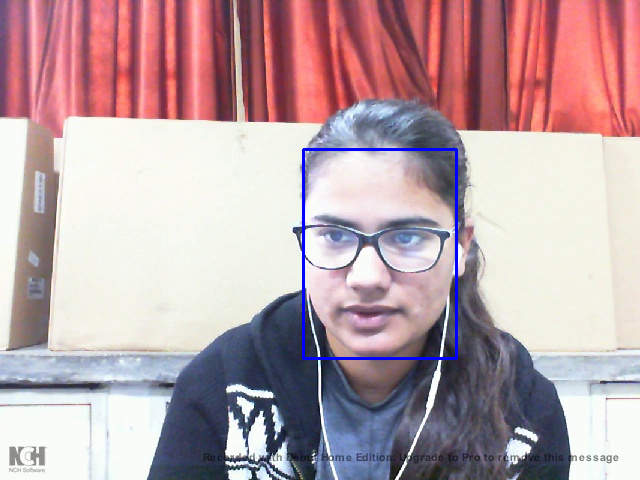

In [43]:
img_with_bbox = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
cv2_imshow(img_with_bbox)

In [21]:
faces = RetinaFace.extract_faces(image_path, align = True)

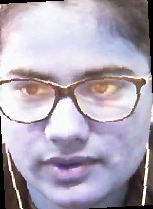

In [22]:
cv2_imshow(faces[0])

In [ ]:
# img = cv2.imread(image_path)
# bbox = get_face_bbox(image_path)
# if bbox:
#   x1, y1, x2, y2 = bbox
# else:
#   print("No face")

In [ ]:
# img = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
# cv2_imshow(img)

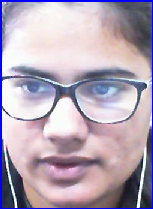

In [23]:
cropped_face = img[y1:y2, x1:x2]
cv2_imshow(cropped_face)

In [26]:
aligned_img = alignment_procedure(img, left_eye, right_eye, nose)

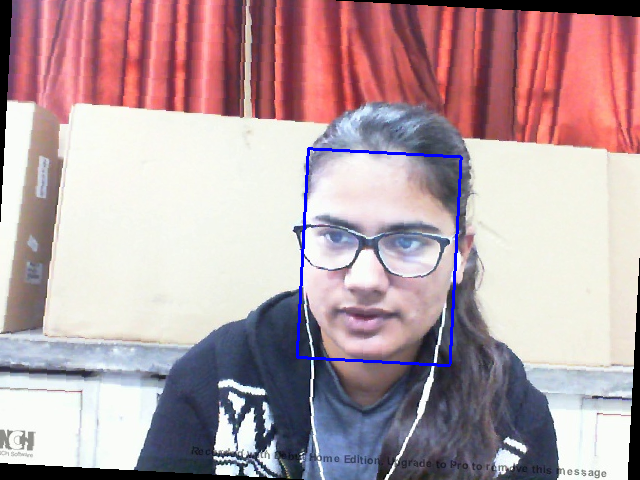

In [27]:
cv2_imshow(aligned_img)

### Main

In [ ]:
import json

In [ ]:
def update_list_of_items(filepath, new_item):
  with open(filepath, "r") as f:
    list_of_items = json.loads(f.read())
  
  list_of_items.append(new_item)

  with open(filepath, "w") as f:
    f.write(json.dumps(list_of_items))

  print(f"Updated '{filepath}'.\n")

In [ ]:
train_already_proccessed_file = "notebooks/train_already_proccessed_sub_folders"

In [ ]:
with open(train_already_proccessed_file, "r") as f:
  train_already_proccessed_sub_folders = json.loads(f.read())

len(train_already_proccessed_sub_folders)

84

In [ ]:
# train frames

face_not_found_frames = []

for i, sub_folder in enumerate(sorted(os.listdir(train_frames_dir))):
  if sub_folder in train_already_proccessed_sub_folders:
    print(f"{ i + 1} / {len(os.listdir(train_frames_dir))}, {sub_folder} Already processed, skipping it.")
    continue

  print(f"{ i + 1} / {len(os.listdir(train_frames_dir))}, {sub_folder}")
  for frame in tqdm(sorted(os.listdir(os.path.join(train_frames_dir, sub_folder)))):
    if frame.endswith(".txt"):
      continue

    frame_path = os.path.join(train_frames_dir, sub_folder, frame)
    bbox = get_face_bbox(frame_path)

    if not bbox:
      face_not_found_frames.append(frame_path)
      continue

    bbox_filepath = frame_path.replace(".jpg", ".txt")
    with open(bbox_filepath, "w") as fin:
      fin.write(" ".join(map(str, bbox)))

  update_list_of_items(filepath=train_already_proccessed_file, new_item=sub_folder)

1 / 84, subject_50_Vid_1 Already processed, skipping it.
2 / 84, subject_50_Vid_2 Already processed, skipping it.
3 / 84, subject_50_Vid_3 Already processed, skipping it.
4 / 84, subject_50_Vid_4 Already processed, skipping it.
5 / 84, subject_50_Vid_5 Already processed, skipping it.
6 / 84, subject_50_Vid_6 Already processed, skipping it.
7 / 84, subject_51_Vid_7 Already processed, skipping it.
8 / 84, subject_52_Vid_7 Already processed, skipping it.
9 / 84, subject_53_Vid_2 Already processed, skipping it.
10 / 84, subject_53_Vid_3 Already processed, skipping it.
11 / 84, subject_53_Vid_4 Already processed, skipping it.
12 / 84, subject_53_Vid_5 Already processed, skipping it.
13 / 84, subject_54_Vid_6 Already processed, skipping it.
14 / 84, subject_55_Vid_6 Already processed, skipping it.
15 / 84, subject_56_Vid_1 Already processed, skipping it.
16 / 84, subject_56_Vid_2 Already processed, skipping it.
17 / 84, subject_56_Vid_3 Already processed, skipping it.
18 / 84, subject_56_Vid

In [ ]:
len(glob.glob(train_frames_dir + "/*/*.jpg"))

64152

In [ ]:
len(glob.glob(train_frames_dir + "/*/*.txt"))

53748

In [ ]:
val_already_proccessed_file = "notebooks/val_already_proccessed_sub_folders"

In [ ]:
with open(val_already_proccessed_file, "r") as f:
  val_already_proccessed_sub_folders = json.loads(f.read())

len(val_already_proccessed_sub_folders)

21

In [ ]:
# validation frames

face_not_found_frames = []

for i, sub_folder in enumerate(sorted(os.listdir(val_frames_dir))):
  if sub_folder in val_already_proccessed_sub_folders:
    print(f"{ i + 1} / {len(os.listdir(val_frames_dir))}, {sub_folder} Already processed, skipping it.")
    continue

  print(f"{ i + 1} / {len(os.listdir(val_frames_dir))}, {sub_folder}")
  for frame in tqdm(sorted(os.listdir(os.path.join(val_frames_dir, sub_folder)))):
    if frame.endswith(".txt"):
      continue

    frame_path = os.path.join(val_frames_dir, sub_folder, frame)
    bbox = get_face_bbox(frame_path)

    if not bbox:
      face_not_found_frames.append(frame_path)
      continue

    bbox_filepath = frame_path.replace(".jpg", ".txt")
    with open(bbox_filepath, "w") as fin:
      fin.write(" ".join(map(str, bbox)))

  update_list_of_items(filepath=val_already_proccessed_file, new_item=sub_folder)

1 / 21, subject_1_Vid_1 Already processed, skipping it.
2 / 21, subject_1_Vid_2 Already processed, skipping it.
3 / 21, subject_1_Vid_3 Already processed, skipping it.
4 / 21, subject_1_Vid_4 Already processed, skipping it.
5 / 21, subject_1_Vid_5 Already processed, skipping it.
6 / 21, subject_2_Vid_6 Already processed, skipping it.
7 / 21, subject_3_Vid_1 Already processed, skipping it.
8 / 21, subject_3_Vid_2 Already processed, skipping it.
9 / 21, subject_3_Vid_3 Already processed, skipping it.
10 / 21, subject_3_Vid_4 Already processed, skipping it.
11 / 21, subject_3_Vid_5 Already processed, skipping it.
12 / 21, subject_3_Vid_7 Already processed, skipping it.
13 / 21, subject_4_Vid_6 Already processed, skipping it.
14 / 21, subject_5_Vid_6 Already processed, skipping it.
15 / 21, subject_6_Vid_6 Already processed, skipping it.
16 / 21, subject_7_Vid_1 Already processed, skipping it.
17 / 21, subject_7_Vid_2 Already processed, skipping it.
18 / 21, subject_7_Vid_3 Already process

In [ ]:
len(face_not_found_frames)

0

In [ ]:
len(glob.glob(val_frames_dir + "/*/*.jpg"))

21971

In [ ]:
len(glob.glob(val_frames_dir + "/*/*.txt"))

18791